# Cytosol Only Cellpose Segmentation with adapted parameters to cellpose model call

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project_cytosol_only_custom_segmentation"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1_custom_params.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[27/02/2025 18:08:54] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_on
         ly_custom_segmentation/scportrait.sdata                                                                   
[27/02/2025 18:08:54] Compression algorithm for extracted single-cell images: lzf
[27/02/2025 18:08:54] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[27/02/2025 18:08:55] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_x_6va4cp for Project
[27/02/2025 18:08:56] Image input_image written to sdata object.
[27/02/2025 18:08:56] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_x_6va4cp'>


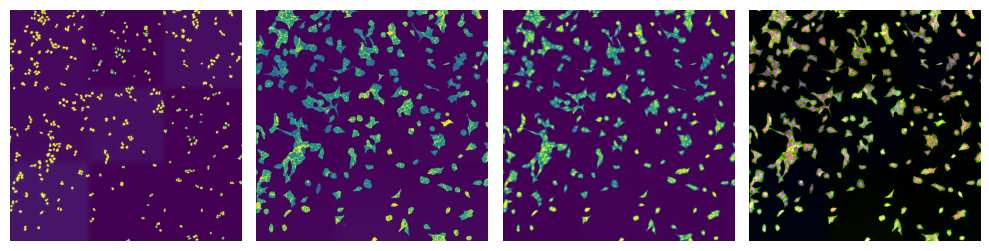

In [ ]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

from scportrait.plotting.vis import generate_composite

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

In [5]:
from scportrait.data._datasets import custom_cellpose_model
custom_model_path = custom_cellpose_model()

project.config["CytosolOnlySegmentationCellpose"]["cytosol_segmentation"]["model_path"] = custom_model_path
project._update_segmentation_f(CytosolOnlySegmentationCellpose)

In [6]:
project.segment()

[27/02/2025 18:09:50] GPU Status for segmentation is True and will segment using the following device mps.
[27/02/2025 18:09:50] Segmentation will be performed wtih all 1 found GPUs.
[27/02/2025 18:09:50] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[27/02/2025 18:09:50] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/02/2025 18:10:03] Segmentation seg_all_cytosol written to sdata object.
[27/02/2025 18:10:05] Points centers_seg_all_cytosol written to sdata object.


(-0.5, 3036.5, 3038.5, -0.5)

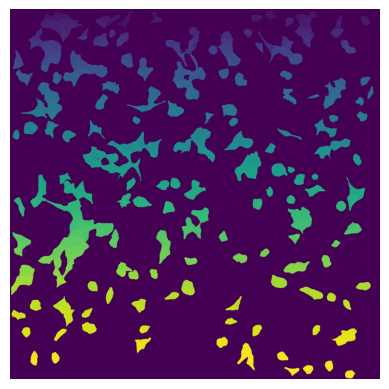

In [7]:
plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [8]:
project.extract()

[27/02/2025 18:10:06] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_304_s36u for HDF5CellExtraction
[27/02/2025 18:10:06] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[27/02/2025 18:10:06] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[27/02/2025 18:10:06] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[27/02/2025 18:10:06] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[27/02/2025 18:10:06] A total of 10 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait

Extracting cell batches: 100%|██████████| 5/5 [00:00<00:00, 25.28it/s]


[27/02/2025 18:10:07] Finished extraction in 0.48 seconds (942.79 cells / second)
[27/02/2025 18:10:07] Benchmarking times saved to file.
[27/02/2025 18:10:07] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_304_s36u'>


(448, 4, 128, 128)


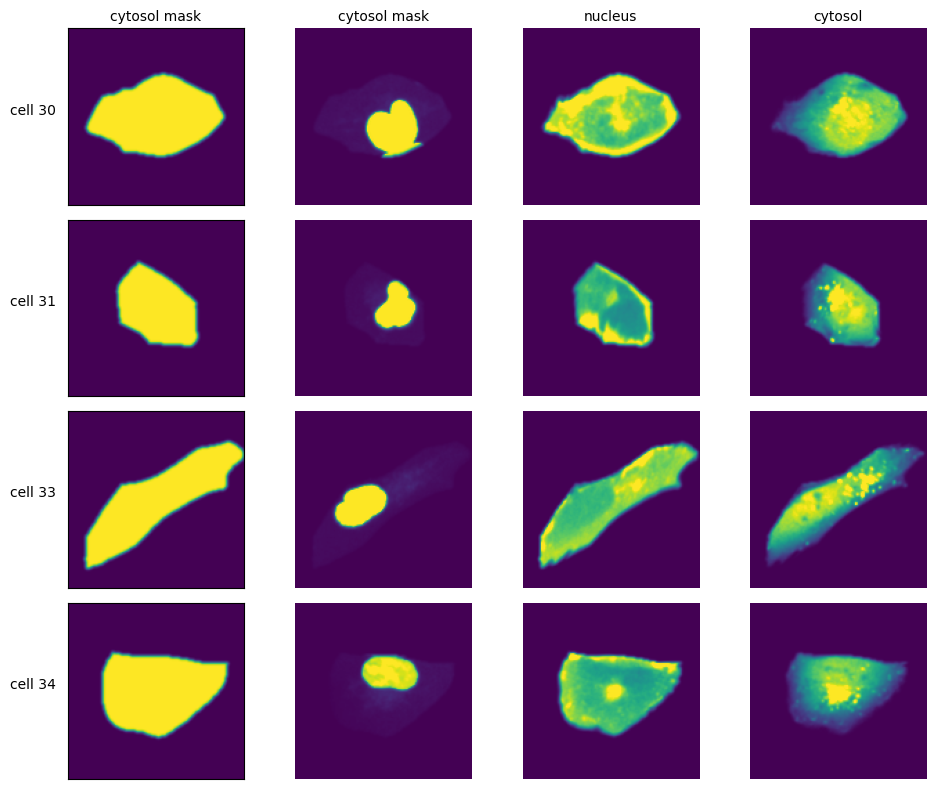

In [9]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 4, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [10]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data/single_cells.h5
[27/02/2025 18:10:07] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_huftjlbq for CellFeaturizer
[27/02/2025 18:10:07] Started CellFeaturization of all available channels.
[27/02/2025 18:10:07] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/featurization/complete_CellFeaturizer
[27/02/2025 18:10:07] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[27/02/2025 18:10:07] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extracti

In [10]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

cytosol_area  1_mean_cytosol  1_median_cytosol  1_quant75_cytosol  \
0          6873.0        0.073960               0.0           0.026337   
1          4115.0        0.055963               0.0           0.000000   
2          3336.0        0.045540               0.0           0.000000   
3          5174.0        0.074726               0.0           0.014950   
4          5612.0        0.058247               0.0           0.013548   
..            ...             ...               ...                ...   
443        4322.0        0.034705               0.0       1.192093e-07   
444        3367.0        0.059293               0.0       0.000000e+00   
445        5732.0        0.038607               0.0       1.976490e-03   
446        5702.0        0.052232               0.0       2.714634e-03   
447        5475.0        0.044407               0.0       1.063108e-03   

     1_quant25_cytosol  1_summed_intensity_cytosol  \
0                  0.0                  1217.12320   
1                  0.0                   912.70465   
2                  0.0                  1257.19580   
3                  0.0                   754.73960   
4                  0.0                   950.43726   
..                 ...                         ...   
443                0.0                   568.61390   
444                0.0                   971.45447   
445                0.0                   632.53420   
446                0.0                   855.76470   
447                0.0                   727.57240   

     1_summed_intensity_area_normalized_cytosol  2_mean_cytosol  \
0                                      0.171934        0.241966   
1                                      0.228519        0.112229   
2                                      0.238286        0.204703   
3                                      0.217316        0.105156   
4                                      0.171312        0.183825   
..                                          ...             ...   
443                                    0.131563        0.142765   
444                                    0.288522        0.103433   
445                                    0.110351        0.204987   
446                                    0.150082        0.179016   
447                                    0.132890        0.168903   

     2_median_cytosol  2_quant75_cytosol  ...  2_summed_intensity_cytosol  \
0                 0.0           0.678833  ...                   3964.3662   
1                 0.0           0.000000  ...                   1838.7552   
2                 0.0           0.144440  ...                   3353.8599   
3                 0.0           0.000000  ...                   1722.8801   
4                 0.0           0.129028  ...                   3011.7910   
..                ...                ...  ...                         ...   
443               0.0           0.000002  ...                   2339.0610   
444               0.0           0.000000  ...                   1694.6521   
445               0.0           0.249817  ...                   3358.5151   
446               0.0           0.348267  ...                   2932.9960   
447               0.0           0.060493  ...                   2767.2993   

     2_summed_intensity_area_normalized_cytosol  3_mean_cytosol  \
0                                      0.560018        0.139019   
1                                      0.460379        0.103986   
2                                      0.635682        0.154936   
3                                      0.496078        0.093468   
4                                      0.542861        0.133257   
..                                          ...             ...   
443                                    0.541199        0.095624   
444                                    0.503312        0.082101   
445                                    0.585924        0.124530   
446                                    0.514380        0.134413   


In [11]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

[27/02/2025 18:10:09] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_zf4mcvlk for LMDSelection
[27/02/2025 18:10:09] Selection process started.


Processing cell batches: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


[27/02/2025 18:10:17] Temporary directory not found, skipping cleanup
[27/02/2025 18:10:17] Temporary directory not found, skipping cleanup
[27/02/2025 18:10:17] Temporary directory not found, skipping cleanup
[27/02/2025 18:10:18] Coordinate lookup index calculation took 8.108338209334761 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

creating shapes:   0%|          | 0/35 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons:   9%|▊         | 3/35 [00:02<00:24,  1.29it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 35/35 [00:03<00:00, 10.26it/s]


Current path length: 37,895.11 units
Optimized path length: 15,986.20 units
Optimization factor: 2.4x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets:  50%|█████     | 1/2 [00:13<00:13, 13.73s/it]

calculating polygons: 100%|██████████| 83/83 [00:10<00:00,  7.64it/s]


Current path length: 83,648.03 units
Optimized path length: 26,933.88 units
Optimization factor: 3.1x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:25<00:00, 12.95s/it]


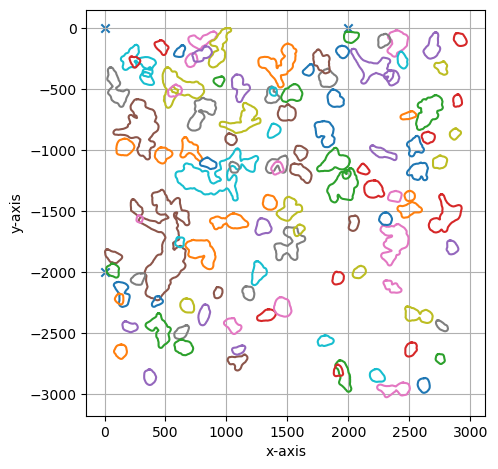

===== Collection Stats =====
Number of shapes: 118
Number of vertices: 17,076
Mean vertices: 145
Min vertices: 59
5% percentile vertices: 73
Median vertices: 102
95% percentile vertices: 322
Max vertices: 856
[0 0]
[      0 -200000]
[200000      0]
[27/02/2025 18:10:44] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/selection/large_cells_small_cells.xml
[27/02/2025 18:10:44] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_zf4mcvlk'>


In [12]:
project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)